In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
#nltk
import nltk
#stop-words
from nltk.corpus import stopwords
# tokenizing
from nltk import word_tokenize
# Beautiful Soup
from bs4 import BeautifulSoup 
# regex
import re
#word2vec
from gensim.models import Word2Vec
#machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
#plot
from pylab import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

### 读入评论文本数据

In [6]:
data = pd.read_csv('employee_reviews.csv')
reviews = data[['company', 'pros', 'cons']]

### 评论文本预处理

In [7]:
def clean_reviews(review):
    #Removing html tags
    review_text = BeautifulSoup(review).get_text()
    #Retaining only alphabets.
    review_text = re.sub("[^a-zA-Z]"," ",review_text)   
    #Converting to lower case and splitting
    word_tokens= review_text.lower().split()
    #Remove stopwords
    stop_words= set(stopwords.words("english"))     
    word_tokens= [w for w in word_tokens if not w in stop_words]
    #from words back to reviews
    cleaned_review=" ".join(word_tokens)
    return cleaned_review

In [8]:
#clean reviews
reviews['pros']=reviews['pros'].apply(clean_reviews)
reviews['cons']=reviews['cons'].apply(clean_reviews)
#combine pros and cons
reviews['review'] = reviews['pros']+' '+reviews['cons']

### IF-IDF和卡方检验

In [11]:
#计算TFIDF 
def calculateTFIDF(doc_str_list_train, doc_str_list_test, fs_num):
    vect =TfidfVectorizer(max_features= fs_num)
    doc_train_vec=vect.fit_transform(doc_str_list_train)
    doc_test_vec=vect.transform(doc_str_list_test)
    return doc_train_vec, doc_test_vec

#根据开方检验特征选择算法计算文档集中各个文档的词与类别的开方值
def calculateCHI(doc_str_list_train, doc_str_list_test,doc_class_list_train, fs_num):
    vect =TfidfVectorizer()
    doc_train_vec_tf=vect.fit_transform(doc_str_list_train)
    doc_test_vec_tf=vect.transform(doc_str_list_test)
    vectCHI = SelectKBest(chi2, k=fs_num)#选择k个最佳特征
    doc_train_vec = vectCHI.fit_transform(doc_train_vec_tf, doc_class_list_train)        
    doc_test_vec = vectCHI.transform(doc_test_vec_tf)
    return doc_train_vec, doc_test_vec

### 信息增益和期望交叉熵

In [36]:
#得到类的字典
def get_class_dict(doc_class_list):
    class_set = sorted(list(set(doc_class_list)))
    class_dict = dict(zip(class_set, range(len(class_set))))#class set 排序后，按照索引做出字典
    return  class_dict

#得到词的字典
def get_term_dict(doc_terms_list):
    term_set_dict = {}
    for doc_terms in doc_terms_list:
        for term in doc_terms:
            term_set_dict[term] = 1
    term_set_list = sorted(term_set_dict.keys())       
    term_set_dict = dict(zip(term_set_list, range(len(term_set_list))))#term set 排序后，按照索引做出字典
    return term_set_dict

#得到类和类文档频数的字典
def stats_class_df(doc_class_list, class_dict):
    class_df_list = [0] * len(class_dict)
    for doc_class in doc_class_list:
        class_df_list[class_dict[doc_class]] += 1
    return class_df_list

#得到词和类的对应矩阵
def stats_term_class_df(doc_terms_list, doc_class_list, term_dict, class_dict):
    term_class_df_mat = np.zeros((len(term_dict), len(class_dict)), np.float32)
    for k in range(len(doc_class_list)):
        class_index = class_dict[doc_class_list[k]]
        doc_terms = doc_terms_list[k]
        for term in set(doc_terms):
            term_index = term_dict[term]
            term_class_df_mat[term_index][class_index] +=1
    return term_class_df_mat

#信息增益
def calculateInformationGain(class_df_list, term_set, term_class_df_mat):
    A = term_class_df_mat#每个数代表一个特征出现属于某类别的文档数
    B = np.array([(sum(x) - x).tolist() for x in A])
    C = np.tile(class_df_list, (A.shape[0], 1)) - A
    N = sum(class_df_list)#总文档数（总评论数）
    D = N - A - B - C
    term_df_array = np.sum(A, axis = 1)#所有词出现过的文档数的矩阵
    class_set_size = len(class_df_list)#class的数量
    p_c_mat = np.array(class_df_list)/sum(class_df_list)

    p_t = term_df_array / N #Pt
    p_not_t = 1 - p_t
    p_c_t_mat =  (A + 1) / (A + B + class_set_size)
    p_c_not_t_mat = (C+1) / (C + D + class_set_size)
    p_c_t = np.sum(p_c_t_mat  *  np.log2(p_c_t_mat), axis =1)
    p_c_not_t = np.sum(p_c_not_t_mat *  np.log2(p_c_not_t_mat), axis =1)

    h_c_t = -(p_t * p_c_t + p_not_t * p_c_not_t)
    h_c = - np.sum(p_c_mat *  np.log2(p_c_mat))
    term_score_array = h_c - h_c_t
    sorted_term_score_index = term_score_array.argsort()[: : -1]
    term_set_fs = [term_set[index] for index in sorted_term_score_index]   
    return term_set_fs

#期望交叉熵
def calculateKL(class_df_list, term_set, term_class_df_mat):
    A = term_class_df_mat#每个数代表一个特征出现属于某类别的文档数
    B = np.array([(sum(x) - x).tolist() for x in A])
    N = sum(class_df_list)#总文档数（总评论数）
    term_df_array = np.sum(A, axis = 1)#所有词出现过的文档数的矩阵
    class_df_array = np.sum(A, axis = 0)
    class_set_size = len(class_df_list)#class的数量
    sorted_term_score_index = []

    p_t = term_df_array / N #Pt
    p_c_t_mat =  (A + 1) / (A + B + class_set_size)
    p_c_mat = np.array(class_df_list)/sum(class_df_list)
    ece = p_t * np.sum(p_c_t_mat * np.log(p_c_t_mat/ p_c_mat), axis = 1)
    cd = np.array([(x/sum(x)).tolist() for x in A])
    dd = A/np.sum(A, axis = 0)      
    cd_ece = [cd[:,i]*dd[:,i]*ece for i in range(len(class_df_list))]

    term_score_array = np.sum(np.array(cd_ece), axis = 0)
    sorted_term_score_index = term_score_array.argsort()[: : -1]
    term_set_fs = [term_set[index] for index in sorted_term_score_index]   
    return term_set_fs

def feature_selection(doc_str_list, doc_class_list, fs_method):
    vectorizer = CountVectorizer(binary = True)   
    word_tokenizer = vectorizer.build_tokenizer()
    doc_terms_list = [word_tokenizer(doc_str) for doc_str in doc_str_list]
    
    class_dict = get_class_dict(doc_class_list)
    term_dict = get_term_dict(doc_terms_list)
    class_df_list = stats_class_df(doc_class_list, class_dict)#每种类别的数量dict
    term_class_df_mat = stats_term_class_df(doc_terms_list, doc_class_list, term_dict, class_dict)
    term_set = [term[0] for term in sorted(term_dict.items(), key = lambda x : x[1])]
    term_set_fs = []
    
    if fs_method == 'IG':
        term_set_fs = calculateInformationGain(class_df_list, term_set, term_class_df_mat)
    elif fs_method == 'ECE':
        term_set_fs = calculateKL(class_df_list, term_set, term_class_df_mat)
    
    return term_set_fs

### Word2Vec

In [31]:
# clean corpus
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences=[]
for attr in ['pros', 'cons']:
    for review in reviews[[attr]].iloc[:,0]:
        sents=tokenizer.tokenize(review.strip()) #分割句子
        for sent in sents:
            cleaned_sent=clean_reviews(sent)
            sentences.append(cleaned_sent.split())

In [37]:
#word2vec
def word2vec_class(fs_num):
    w2v_model=Word2Vec(sentences,size=fs_num,window=10,min_count=40) # try to tune parameters.
    w2v_model.train(sentences,total_examples=len(sentences),epochs=10)
    doc_vectors_train=[]
    i = 0
    for review in reviews['review']:
        doc_vectors = make_doc_vectors(review,fs_num,w2v_model)
        doc_vectors_train.append(doc_vectors)
    doc_vectors_train=np.array(doc_vectors_train)
    Y=np.array(list(reviews['company']))
    x,x_test,y,y_test=train_test_split(doc_vectors_train,Y,test_size=0.20,random_state=42)
    clf = LogisticRegression().fit(x, y)  #调用logistic分类器
    doc_test_predicted = clf.predict(x_test)
    acc = np.mean(doc_test_predicted == y_test)  
    return acc

#word vector to document vector
def make_doc_vectors(review,fs_num,w2v_model):
    doc_vec=np.zeros(fs_num,dtype='float64') # initialize with zeros.
    words=review.split()
    for word in words: # iterate over all words.
        if word in w2v_model.wv.vocab:
            word_vec=w2v_model.wv.get_vector(word) # if word in vocab add its word vector to our doc vector
            doc_vec=doc_vec+word_vec
    return doc_vec/len(words)  # returning the averaged word vector ie the 'doc vector' for us. 

### 分类任务比较模型

In [38]:
acc_dict = {}    
fs_method_list = ['TFIDF', 'CHI', 'IG', 'ECE', 'Word2Vec']
fs_num_list = range(100, 1000, 100)
    
for fs_method in fs_method_list:
    acc_list = []
    if fs_method in ['Word2Vec']:
        for fs_num in fs_num_list:
            #print('fs method:' + fs_method, 'fs num:' + str(fs_num))
            acc = word2vec_class(fs_num)
            #print('Accuracy: ', acc)
            acc_list.append(acc)            
    else:
        doc_str_list_train, doc_str_list_test, doc_class_list_train, doc_class_list_test = train_test_split(reviews['review'], reviews['company'], test_size = 0.2, random_state = 0)
        doc_str_list_train.reset_index(inplace=True,drop=True)
        doc_str_list_test.reset_index(inplace=True,drop=True)
        doc_class_list_train.reset_index(inplace=True,drop=True)
        doc_class_list_test.reset_index(inplace=True,drop=True)
        if fs_method in ['TFIDF', 'CHI']:
            for fs_num in fs_num_list:        
                #print('fs method:' + fs_method, 'fs num:' + str(fs_num))
                if fs_method == 'TFIDF':
                    doc_train_vec, doc_test_vec = calculateTFIDF(doc_str_list_train, doc_str_list_test, fs_num)
                elif fs_method == 'CHI':
                    doc_train_vec, doc_test_vec = calculateCHI(doc_str_list_train, doc_str_list_test, doc_class_list_train, fs_num)
                clf = LogisticRegression().fit(doc_train_vec, doc_class_list_train)
                doc_test_predicted = clf.predict(doc_test_vec)
                acc = np.mean(doc_test_predicted == doc_class_list_test)  
                #print('Accuracy: ', acc)
                acc_list.append(acc)
        elif fs_method in ['IG', 'ECE']:
            term_fs = feature_selection(doc_str_list_train, doc_class_list_train, fs_method)
            for fs_num in fs_num_list:
                #print('fs method:' + fs_method, 'fs num:' + str(fs_num))
                term_set_fs = term_fs[:fs_num]
                term_dict = dict(zip(term_set_fs, range(len(term_set_fs))))
                vectorizer = CountVectorizer(binary = True, vocabulary = term_dict)
                doc_train_vec = vectorizer.fit_transform(doc_str_list_train)
                doc_test_vec= vectorizer.transform(doc_str_list_test)
                clf = LogisticRegression().fit(doc_train_vec, doc_class_list_train)
                doc_test_predicted = clf.predict(doc_test_vec)
                acc = np.mean(doc_test_predicted == doc_class_list_test)  
                #print('Accuracy: ', acc)
                acc_list.append(acc)
    acc_dict[fs_method] = acc_list
    #print('fs method:', acc_dict[fs_method])

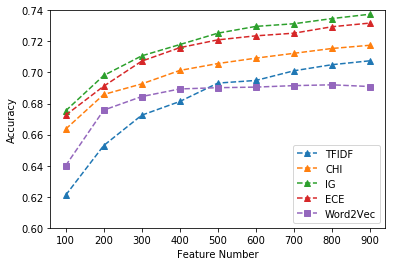

In [43]:
for fs_method in fs_method_list:
    if fs_method in ['TFIDF', 'CHI', 'IG', 'ECE']:
        plt.plot(fs_num_list, acc_dict[fs_method],  '--^',  label = fs_method)
    else:
        plt.plot(fs_num_list, acc_dict[fs_method],  '--s',  label = fs_method)
    plt.xlabel('Feature Number')
    plt.ylabel("Accuracy")
    plt.ylim((0.600, 0.740))

plt.legend( loc='lower right', numpoints = 1)
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.3f'))
plt.show()